In [1]:
import math
import numpy as np
import wandb
import pickle
import os
import shapely.wkt as wkt
import pandas as pd
import geopandas as gpd
from shapely.geometry import LineString
from torch_geometric.transforms import LineGraph

import gzip
import xml.etree.ElementTree as ET

import torch
import torch_geometric
from torch_geometric.data import Data

import processing_io as pio
import sys
import os
import joblib
import json

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from shapely.geometry import Point, LineString, box
from matplotlib.colors import TwoSlopeNorm

from shapely.ops import unary_union
from mpl_toolkits.axes_grid1 import make_axes_locatable
from torch_geometric.data import Data, Batch
import torch
from torch_geometric.data import Data


districts = gpd.read_file("../../data/visualisation/districts_paris.geojson")

# Add the 'scripts' directory to the Python path
scripts_path = os.path.abspath(os.path.join('..'))
if scripts_path not in sys.path:
    sys.path.append(scripts_path)

import gnn_io as gio
import gnn_architectures as garch

# Assuming 'highway_mapping' and 'encode_modes' are defined as in your context
highway_mapping = {
    'residential': 0, 'tertiary': 1, 'living_street': 2, 'secondary': 3, 
    'primary': 4, 'trunk_link': 5, 'primary_link': 6, 'motorway': 7, 
    'service': 8, 'unclassified': 9, 'secondary_link': 10, 
    'pedestrian': 11, 'trunk': 12, 'motorway_link': 13, 
    'construction': 14, 'tertiary_link': 15, np.nan: -1
}

In [2]:
# Parameters to define
run_path = '/home/enatterer/Development/gnn_predicting_effects_of_traffic_policies/data/runs_NEW/hidden_64_hidden_layer_str_[64]_/'
model_path = run_path +  'trained_model/model.pth'
data_created_during_training = run_path + 'data_created_during_training/'
indices_of_datasets_to_use = [0, 1, 3, 4]

scaler_y = joblib.load(data_created_during_training + 'y_scaler.pkl')
scaler_x = joblib.load(data_created_during_training + 'x_scaler.pkl')
scaler_pos = joblib.load(data_created_during_training + 'pos_scaler.pkl')

# Load the test dataset created during training
test_set_dl = torch.load(data_created_during_training + 'test_dl.pt')

# Load the DataLoader parameters
with open(data_created_during_training + 'test_loader_params.json', 'r') as f:
    test_set_dl_loader_params = json.load(f)
    
# Remove or correct collate_fn if it is incorrectly specified
if 'collate_fn' in test_set_dl_loader_params and isinstance(test_set_dl_loader_params['collate_fn'], str):
    del test_set_dl_loader_params['collate_fn']  # Remove it to use the default collate function
    
test_set_loader = torch.utils.data.DataLoader(test_set_dl, **test_set_dl_loader_params)

In [3]:
dataset = test_set_loader.dataset

# Select the device (CPU in this example)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move reference values to the same device
reference_x_column = dataset[0].x[:, 2].to(device)
reference_y = dataset[0].y.to(device)

# Initialize flags to check if all values are the same
all_x_columns_same = True
all_y_same = True

# Iterate through the dataset
for data in test_set_loader.dataset:
    # Move data to the same device
    data_x_column = data.x[:, 2].to(device)
    data_y = data.y.to(device)
    
    # Compare the third column of x values
    if not torch.equal(data_x_column, reference_x_column):
        all_x_columns_same = False

    # Compare the y values
    if not torch.equal(data_y, reference_y):
        all_y_same = False

    # Break early if both are found to be different
    if not all_x_columns_same and not all_y_same:
        break

# Print results
print(f"All third columns of x are the same: {all_x_columns_same}")
print(f"All y values are the same: {all_y_same}")

All third columns of x are the same: False
All y values are the same: False


In [4]:
len(test_set_loader.dataset)

4887

In [5]:
test_data = "../../data/test_data/pop_1pm_policy_in_zone_1.geojson"
test_data = gpd.read_file(test_data)
base_case = "../../data/test_data/gdf_basecase_mean_pop_1pm.geojson"
base_case = gpd.read_file(base_case)

test_input_linegraph = pio.create_test_data_object(base_case=base_case, test_data = test_data) # check this function if there have been changes in the features of the data
test_data_list = [test_input_linegraph] # we do it for just one test data object, for now.

dataset_only_relevant_dimensions = gio.cut_dimensions(dataset=test_data_list, indices_of_dimensions_to_keep=indices_of_datasets_to_use)
dataset_normalized = gio.normalize_dataset(dataset_only_relevant_dimensions, y_scalar=scaler_y, x_scalar_list=scaler_x, pos_scalar=scaler_pos, directory_path=None)
test_dl = gio.create_dataloader(dataset=dataset_normalized, is_train=False, batch_size=16, train_ratio=0, is_test=True)

AttributeError: module 'gnn_io' has no attribute 'normalize_dataset'

In [ ]:
# Example of how to initialize your model
in_channels = 6  # Example value
out_channels = 1  # Example value
hidden_layers_base_for_point_net_conv = 64
hidden_layer_structure = [64,64]  # Example value

# Initialize the model
model = garch.MyGnn(in_channels=in_channels, out_channels=out_channels, hidden_layers_base_for_point_net_conv=hidden_layers_base_for_point_net_conv, hidden_layer_structure=hidden_layer_structure)

# Load the model state dictionary
model.load_state_dict(torch.load(model_path))

Initializing PointNetConv(local_nn=Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
), global_nn=Sequential(
  (0): Linear(in_features=64, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=128, bias=True)
  (3): ReLU()
  (4): Linear(in_features=128, out_features=64, bias=True)
))
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 0.weight with kaiming_normal
Initializing 0.bias with zeros
Initializing 2.weight with kaiming_normal
Initializing 2.bias with zeros
Initializing 4.weight with kaiming_normal
Initializing 4.bias with zeros
Initializing Linear(in_features=6, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=64, bias=True)
Initializing Linear(in_features=64, out_features=32, bias=True)
Initializing Linear(in_features=32, 

<All keys matched successfully>

In [ ]:
def validate_model(model, valid_dl, loss_func, device):
    model.eval()
    val_loss = 0
    num_batches = 0
    
    actual_vals = []
    predictions = []
    
    with torch.inference_mode():
        for idx, data in enumerate(valid_dl):
            input_node_features, targets = data.x.to(device), data.y.to(device)
            predicted = model(data.to(device))
            actual_vals.append(targets)
            predictions.append(predicted)
            val_loss += loss_func(predicted, targets).item()
            num_batches += 1
            
    actual_vals_cat = torch.cat(actual_vals)
    predictions_cat = torch.cat(predictions)
    r_squared = compute_r2_torch(preds=predictions_cat, targets=actual_vals_cat)
    return val_loss / num_batches if num_batches > 0 else 0, r_squared, actual_vals, predictions

def validate_one_model(model, data, loss_func, device):
    model.eval()
    val_loss = 0
    num_batches = 0
    
    with torch.inference_mode():
        # for idx, data in enumerate(valid_dl):
        input_node_features, targets = data.x.to(device), data.y.to(device)
        predicted = model(data.to(device))
        val_loss += loss_func(predicted, targets).item()
        num_batches += 1
    r_squared = compute_r2_torch(preds=predicted, targets=targets)
    return val_loss / num_batches if num_batches > 0 else 0, r_squared, targets, predicted

def compute_r2_torch(preds, targets):
    """Compute R^2 score using PyTorch."""
    mean_targets = torch.mean(targets)
    ss_tot = torch.sum((targets - mean_targets) ** 2)
    ss_res = torch.sum((targets - preds) ** 2)
    r2 = 1 - ss_res / ss_tot
    return r2

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)
loss_fct = torch.nn.MSELoss()
test_loss, r_squared, actual_vals, predictions = validate_one_model(model, test_set_dl[0], loss_fct, device)
print(f'Test Loss: {test_loss}')
print(f'r_squared: {r_squared}')
print(f'actual_vals shape: {len(actual_vals)}')
print(f'predictions shape: {len(predictions)}')

Test Loss: 0.24520264565944672
r_squared: 0.7547973394393921
actual_vals shape: 31216
predictions shape: 31216


In [ ]:
def data_to_geodataframe(data, original_gdf, predicted_values):
    # Extract the edge index and node features
    node_features = data.x.cpu().numpy()
    target_values = data.y.cpu().numpy()
    predicted_values = predicted_values.cpu().numpy() if isinstance(predicted_values, torch.Tensor) else predicted_values

    # Create edge data
    edge_data = {
        'from_node': original_gdf["from_node"].values,
        'to_node': original_gdf["to_node"].values,
        'vol_base_case': node_features[:, 0],  # Assuming capacity is the first feature, and so on
        'capacity_base_case': node_features[:, 1],  
        'capacity_reduction': node_features[:, 2],  
        'highway': node_features[:, 3],  
        'vol_car_change_actual': target_values.squeeze(),  # Assuming target values are car volumes
        'vol_car_change_predicted': predicted_values.squeeze()
    }
    # Convert to DataFrame
    edge_df = pd.DataFrame(edge_data)
    # Create LineString geometry
    edge_df['geometry'] = original_gdf["geometry"].values
    # Create GeoDataFrame
    gdf = gpd.GeoDataFrame(edge_df, geometry='geometry')
    return gdf

In [ ]:
def map_to_original_values(input_gdf: gpd.GeoDataFrame):
    gdf = input_gdf.copy()
    original_values_vol_car_change_actual = scaler_y.inverse_transform(gdf['vol_car_change_actual'].values.reshape(-1, 1))
    original_values_vol_car_change_predicted = scaler_y.inverse_transform(gdf['vol_car_change_predicted'].values.reshape(-1, 1))
    original_values_vol_base_case = scaler_x[0].inverse_transform(gdf['vol_base_case'].values.reshape(-1, 1))
    original_values_capacity_base_case = scaler_x[1].inverse_transform(gdf['capacity_base_case'].values.reshape(-1, 1))
    original_values_capacity_new = scaler_x[2].inverse_transform(gdf['capacity_reduction'].values.reshape(-1, 1))
    original_values_highway = scaler_x[3].inverse_transform(gdf['highway'].values.reshape(-1, 1))

    gdf['og_highway'] = original_values_highway
    gdf['og_vol_car_change_actual'] = original_values_vol_car_change_actual
    gdf['og_vol_car_change_predicted'] = original_values_vol_car_change_predicted
    gdf['og_vol_base_case'] = original_values_vol_base_case
    gdf['og_capacity_base_case'] = original_values_capacity_base_case
    gdf['og_capacity_reduction'] = original_values_capacity_new
    return gdf

# gdf.to_file("../../data/visualisation/gdf_pop_1pm_output_diff_1-111.geojson", driver='GeoJSON')

In [ ]:
def list_to_string(integers, delimiter=', '):
    """
    Converts a list of integers into a string, with each integer separated by the specified delimiter.

    Parameters:
    integers (list of int): The list of integers to convert.
    delimiter (str): The delimiter to use between integers in the string.

    Returns:
    str: A string representation of the list of integers.
    """
    return delimiter.join(map(str, integers))


def plot_districts_of_capacity_reduction(gdf_input:gpd.GeoDataFrame, font:str ='DejaVu Serif', save_it: bool=False, number_to_plot : int=0):    
    gdf = gdf_input.copy()
    x_min = gdf.total_bounds[0] + 0.05
    y_min = gdf.total_bounds[1] + 0.05
    x_max = gdf.total_bounds[2]
    y_max = gdf.total_bounds[3]
    bbox = box(x_min, y_min, x_max, y_max)
    
    # Filter the network to include only the data within the bounding box
    gdf = gdf[gdf.intersects(bbox)]
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    gdf = gdf[gdf["og_highway"].isin([1, 2, 3])]
    
    # Round og_capacity_reduction and filter
    gdf['og_capacity_reduction_rounded'] = gdf['og_capacity_reduction'].round(decimals=3)
    tolerance = 1e-3
    edges_with_capacity_reduction = gdf[np.abs(gdf['og_capacity_reduction_rounded']) > tolerance]
    # edges_without_capacity_reduction = gdf[np.abs(gdf['og_capacity_reduction_rounded']) <= tolerance]

    norm = TwoSlopeNorm(vmin=gdf["og_capacity_reduction"].min(), vcenter=gdf["og_capacity_reduction"].median(), vmax=gdf["og_capacity_reduction"].max())
    
    # edges_without_capacity_reduction.plot(
    #     ax=ax, column=column_to_plot, cmap='coolwarm', linewidth=3, legend=False, norm=norm, zorder=1, label = "Capacity reduction")
    edges_with_capacity_reduction.plot(
        ax=ax, column='og_capacity_reduction', cmap='coolwarm', linewidth=5, legend=False, norm=norm, zorder=2, label = "Edges with capacity reduction")
        
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Customize the plot with Times New Roman font and size 15
    plt.xlabel("Longitude", fontname=font, fontsize=15)
    plt.ylabel("Latitude", fontname=font, fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(15)
    ax.legend(prop={'family': font, 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar

    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    
    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname(font)
    cbar.ax.yaxis.label.set_fontname(font)
    cbar.ax.yaxis.label.set_size(15)
    cbar.set_label('Capacity reduction', fontname=font, fontsize=15)
    if save_it:
        plt.savefig("results/gdf_capacity_reduction_" + str(number_to_plot), bbox_inches='tight')
    plt.show()
    
def plot_simulation_output(gdf_input:gpd.GeoDataFrame, column_to_plot: str, font:str ='DejaVu Serif', save_it: bool=False, number_to_plot : int=0, is_predicted:bool= False):    
    gdf = gdf_input.copy()
    x_min = gdf.total_bounds[0] + 0.05
    y_min = gdf.total_bounds[1] + 0.05
    x_max = gdf.total_bounds[2]
    y_max = gdf.total_bounds[3]
    bbox = box(x_min, y_min, x_max, y_max)
    
    # Filter the network to include only the data within the bounding box
    gdf = gdf[gdf.intersects(bbox)]
    
    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    gdf = gdf[gdf["og_highway"].isin([1, 2, 3])]
    
    # Round og_capacity_reduction and filter
    gdf['og_capacity_reduction_rounded'] = gdf['og_capacity_reduction'].round(decimals=3)
    tolerance = 1e-3
    edges_with_capacity_reduction = gdf[np.abs(gdf['og_capacity_reduction_rounded']) > tolerance]
    edges_without_capacity_reduction = gdf[np.abs(gdf['og_capacity_reduction_rounded']) <= tolerance]

    norm = TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)
    
    edges_without_capacity_reduction.plot(
        ax=ax, column=column_to_plot, cmap='coolwarm', linewidth=3, legend=False, norm=norm, zorder=1, label = "Edges without capacity reduction")
    edges_with_capacity_reduction.plot(
        ax=ax, column=column_to_plot, cmap='coolwarm', linewidth=5, legend=False, norm=norm, zorder=2, label = "Edges with capacity reduction")
        
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    
    # Customize the plot with Times New Roman font and size 15
    plt.xlabel("Longitude", fontname=font, fontsize=15)
    plt.ylabel("Latitude", fontname=font, fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(15)
    ax.legend(prop={'family': font, 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar

    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)
    
    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname(font)
    cbar.ax.yaxis.label.set_fontname(font)
    cbar.ax.yaxis.label.set_size(15)
    cbar.set_label('Car volume: Difference to base case (%)', fontname=font, fontsize=15)
    if save_it:
        p = "predicted" if is_predicted else "actual"
        plt.savefig("results/gdf_" + str(number_to_plot) + "_" + p, bbox_inches='tight')
    plt.show()

In [ ]:
# import matplotlib.font_manager as fm

# # List all available fonts
# available_fonts = fm.findSystemFonts(fontpaths=None, fontext='ttf')

# # Create a set of font names for easier readability
# available_font_names = set(fm.FontProperties(fname=font).get_name() for font in available_fonts)

# # Print the available font names
# for font_name in sorted(available_font_names):
#     print(font_name)

In [ ]:
import alphashape
from matplotlib.lines import Line2D

from shapely.geometry import Polygon

def plot_combined_output(gdf_input: gpd.GeoDataFrame, column_to_plot: str, font: str = 'DejaVu Serif', save_it: bool = False, number_to_plot: int = 0, is_predicted: bool = False):
    gdf = gdf_input.copy()
    x_min = gdf.total_bounds[0] + 0.05
    y_min = gdf.total_bounds[1] + 0.05
    x_max = gdf.total_bounds[2]
    y_max = gdf.total_bounds[3]
    bbox = box(x_min, y_min, x_max, y_max)

    # Filter the network to include only the data within the bounding box
    gdf = gdf[gdf.intersects(bbox)]

    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    gdf = gdf[gdf["og_highway"].isin([1, 2, 3])]

    # Round og_capacity_reduction and filter
    gdf['og_capacity_reduction_rounded'] = gdf['og_capacity_reduction'].round(decimals=3)
    tolerance = 1e-3
    edges_with_capacity_reduction = gdf[np.abs(gdf['og_capacity_reduction_rounded']) > tolerance]


    norm = TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)
    gdf.plot(ax=ax, column=column_to_plot, cmap='coolwarm', linewidth=4, legend=False, norm=norm, zorder=1, label="Higher order street network")
    
    # Extract the coordinates of the geometries
    coords = [(x, y) for geom in edges_with_capacity_reduction.geometry for x, y in zip(geom.xy[0], geom.xy[1])]

    # Compute the alpha shape
    alpha = 100  # Adjust this parameter to make the shape tighter or looser
    alpha_shape = alphashape.alphashape(coords, alpha)

    # Create a GeoSeries for the alpha shape with the same CRS
    alpha_shape_gs = gpd.GeoSeries([alpha_shape], crs=gdf.crs)

    # Plot the alpha shape
    alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label = 'Capacity was decreased in this section')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Longitude", fontname=font, fontsize=15)
    plt.ylabel("Latitude", fontname=font, fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(15)
    
    # Create custom legend
    custom_lines = [Line2D([0], [0], color='grey', lw=4, label='Higher order street network'),# Add more lines for other labels as needed
                    Line2D([0], [0], color='black', lw=2, label='Capacity was decreased in this section')]

    ax.legend(handles=custom_lines, prop={'family': font, 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar
    
    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)

    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname(font)
    cbar.ax.yaxis.label.set_fontname(font)
    cbar.ax.yaxis.label.set_size(15)
    cbar.set_label('Car volume: Difference to base case (%)', fontname=font, fontsize=15)
    if save_it:
        p = "predicted" if is_predicted else "actual"
        plt.savefig("results/gdf_" + str(number_to_plot) + "_" + p, bbox_inches='tight')
    plt.show()
    

In [ ]:
def plot_difference_output(gdf_input: gpd.GeoDataFrame, column1: str, column2: str, diff_column: str = 'difference', font: str = 'DejaVu Serif', save_it: bool = False, number_to_plot: int = 0):
    gdf = gdf_input.copy()
    
    # Calculate the difference between the two columns
    gdf[diff_column] = gdf[column1] - gdf[column2]
    
    x_min = gdf.total_bounds[0] + 0.05
    y_min = gdf.total_bounds[1] + 0.05
    x_max = gdf.total_bounds[2]
    y_max = gdf.total_bounds[3]
    bbox = box(x_min, y_min, x_max, y_max)

    # Filter the network to include only the data within the bounding box
    gdf = gdf[gdf.intersects(bbox)]

    # Set up the plot
    fig, ax = plt.subplots(1, 1, figsize=(15, 15))
    gdf = gdf[gdf["og_highway"].isin([1, 2, 3])]

    # Round og_capacity_reduction and filter
    gdf['og_capacity_reduction_rounded'] = gdf['og_capacity_reduction'].round(decimals=3)
    tolerance = 1e-3
    edges_with_capacity_reduction = gdf[np.abs(gdf['og_capacity_reduction_rounded']) > tolerance]
    
    norm = TwoSlopeNorm(vmin=gdf[diff_column].min(), vcenter=gdf[diff_column].median(), vmax=gdf[diff_column].max())

    # norm = TwoSlopeNorm(vmin=-20, vcenter=0, vmax=20)
    gdf.plot(ax=ax, column=diff_column, cmap='coolwarm', linewidth=4, legend=False, norm=norm, zorder=1, label="Higher order street network")
    
    # Extract the coordinates of the geometries
    coords = [(x, y) for geom in edges_with_capacity_reduction.geometry for x, y in zip(geom.xy[0], geom.xy[1])]

    # Compute the alpha shape
    alpha = 100  # Adjust this parameter to make the shape tighter or looser
    alpha_shape = alphashape.alphashape(coords, alpha)

    # Create a GeoSeries for the alpha shape with the same CRS
    alpha_shape_gs = gpd.GeoSeries([alpha_shape], crs=gdf.crs)

    # Plot the alpha shape
    alpha_shape_gs.plot(ax=ax, edgecolor='black', linewidth=2, facecolor='None', zorder=2, label='Capacity was decreased in this section')

    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)
    plt.xlabel("Longitude", fontname=font, fontsize=15)
    plt.ylabel("Latitude", fontname=font, fontsize=15)

    # Customize tick labels
    ax.tick_params(axis='both', which='major', labelsize=10)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname(font)
        label.set_fontsize(15)
    
    # Create custom legend
    custom_lines = [Line2D([0], [0], color='grey', lw=4, label='Higher order street network'),# Add more lines for other labels as needed
                    Line2D([0], [0], color='black', lw=2, label='Capacity was decreased in this section')]

    ax.legend(handles=custom_lines, prop={'family': font, 'size': 15})
    ax.set_position([0.1, 0.1, 0.75, 0.75])
    cax = fig.add_axes([0.87, 0.22, 0.03, 0.5])  # Manually position the color bar
    
    # Create the color bar
    sm = plt.cm.ScalarMappable(cmap='coolwarm', norm=norm)
    sm._A = []
    cbar = plt.colorbar(sm, cax=cax)

    # Set color bar font properties
    cbar.ax.tick_params(labelsize=15)
    for t in cbar.ax.get_yticklabels():
        t.set_fontname(font)
    cbar.ax.yaxis.label.set_fontname(font)
    cbar.ax.yaxis.label.set_size(15)
    cbar.set_label('Difference between predicted and actual (%)', fontname=font, fontsize=15)
    if save_it:
        # p = "predicted_vs_actual" if is_predicted else "actual_vs_predicted"
        plt.savefig("results/gdf_difference_" + str(number_to_plot), bbox_inches='tight')
    plt.show()

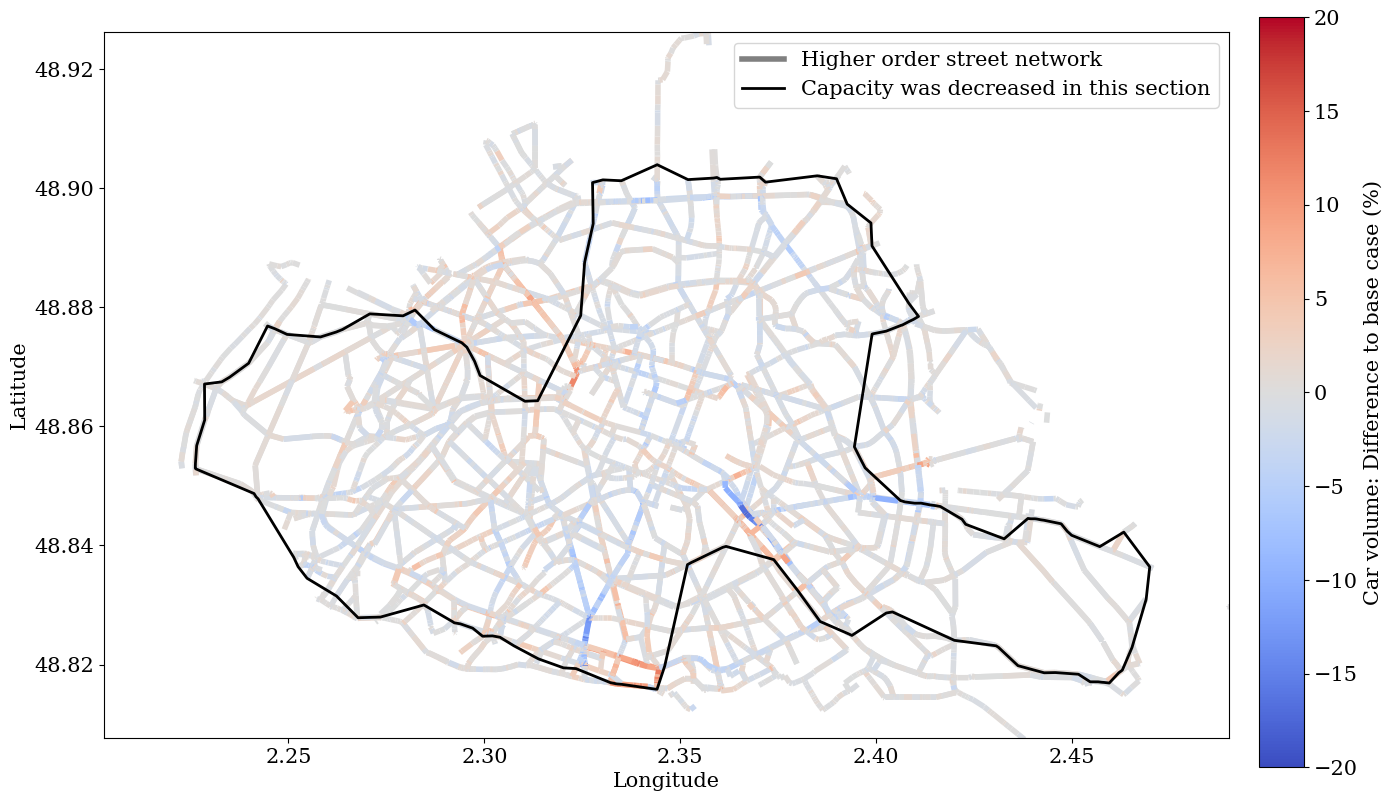

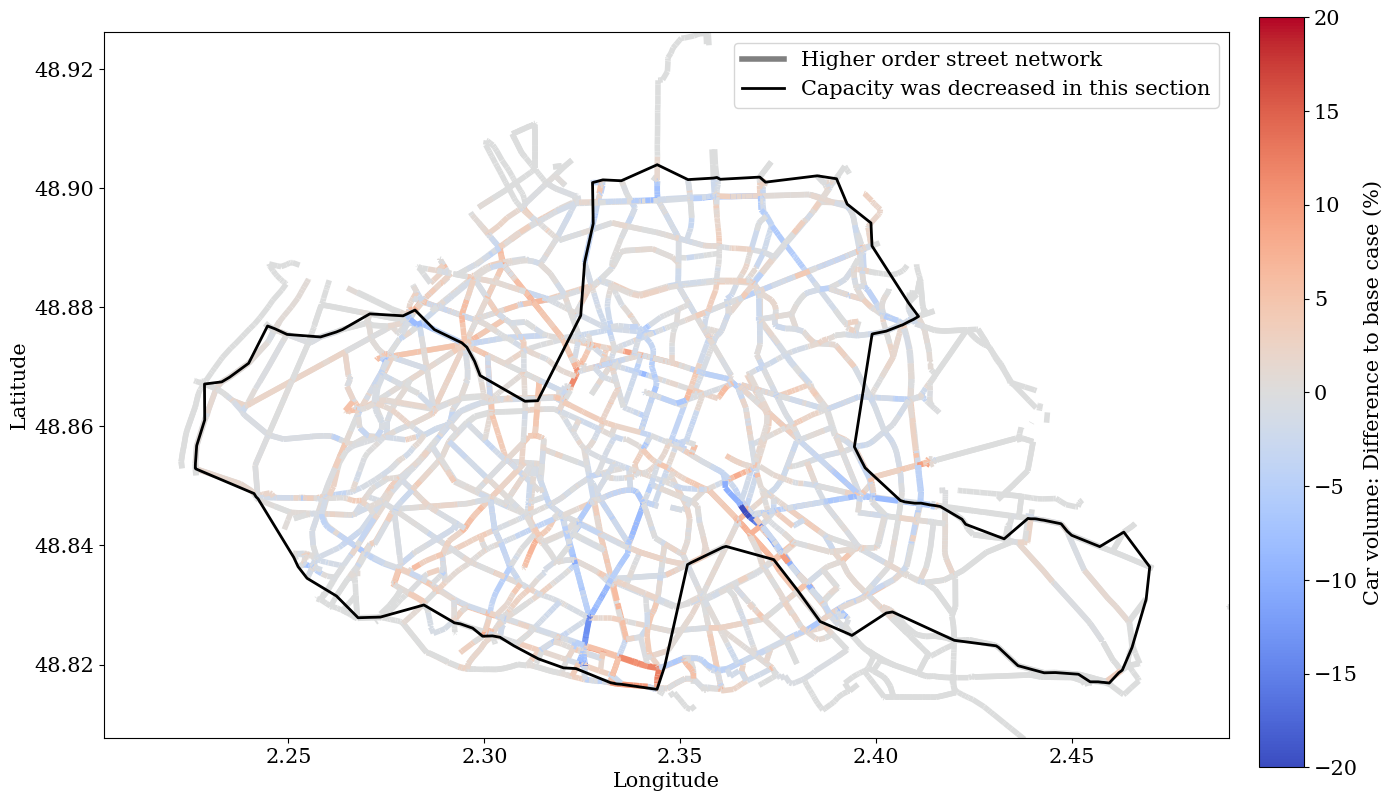

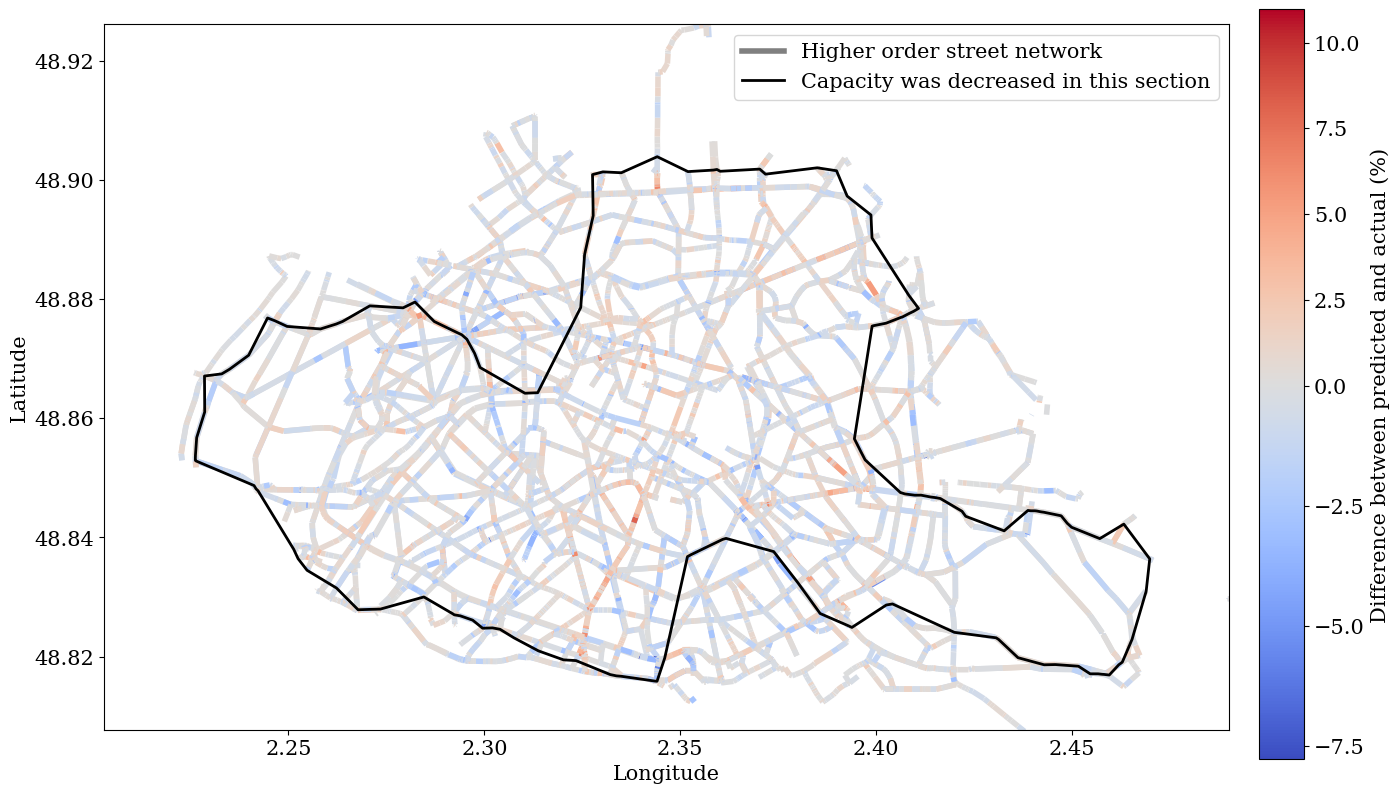

In [ ]:

i= 0
gdf = data_to_geodataframe(data=test_set_loader.dataset[i], original_gdf=test_data, predicted_values=predictions)
gdf_with_og_values = map_to_original_values(input_gdf=gdf)
plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_predicted", save_it=True, number_to_plot=1, is_predicted=True)
plot_combined_output(gdf_input=gdf_with_og_values, column_to_plot="og_vol_car_change_actual", save_it=True, number_to_plot=1, is_predicted=False)
plot_difference_output(gdf_input=gdf_with_og_values, column1="og_vol_car_change_predicted", column2="og_vol_car_change_actual", save_it=True, number_to_plot=1)